In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [81]:
def create_graph_with_degree_distribution(dd, as_adjacency=False):
    """
    Creates a graph with a desired degree distribution (dd). We first throw
    the correct number of links at random into an empty network, and later
    reshuffle them to get the desired distribution. 
    """
    n = len(dd)
    n_links = sum(dd)*0.5
    adj = np.zeros((n, n))
    
    # Create a network with the desired number of links
    links_in_network = 0
    while links_in_network < n_links:
        i, j = np.random.choice(np.arange(n), size=2)
        if (i != j) and (adj[i, j] < 1):
            adj[i, j] = 1
            adj[j, i] = 1
            links_in_network += 1
    
    assert adj.sum() == sum(dd), "Problem with the initialization of the network"
    
    # Shuffle until we find a network with the correct dd
    while sorted(adj.sum(axis=0)) != sorted(dd):
        adjnew = adj.copy()
        
        edgelist = np.where(adj > 0)
        edgelist = [(i, j) for i,j in zip(*edgelist)]
        edge_id = np.random.choice(len(edgelist))
        i_old, j_old = edgelist[edge_id]
        i_new, j_new = np.random.choice(np.arange(n), size=2)
        
        if (i_new != j_new) and (adj[i_new, j_new] < 1):
            adjnew[i_new, j_new] = 1
            adjnew[j_new, i_new] = 1
            adjnew[i_old, j_old] = 0
            adjnew[j_old, i_old] = 0
        
        distance_old = ((np.sort(adj.sum(axis=0)) - np.sort(dd))**2).sum()
        distance_new = ((np.sort(adjnew.sum(axis=0)) - np.sort(dd))**2).sum()
        
        if distance_new < distance_old:
            adj = adjnew.copy()
    
    # Sort the adjacency matrix
    sort = np.argsort(adj.sum(axis=0))[::-1]
    adj = adj[sort, :][:, sort]
    
    if as_adjacency is False:
        g = nx.from_numpy_matrix(adj)
        return g
    else:
        return adj

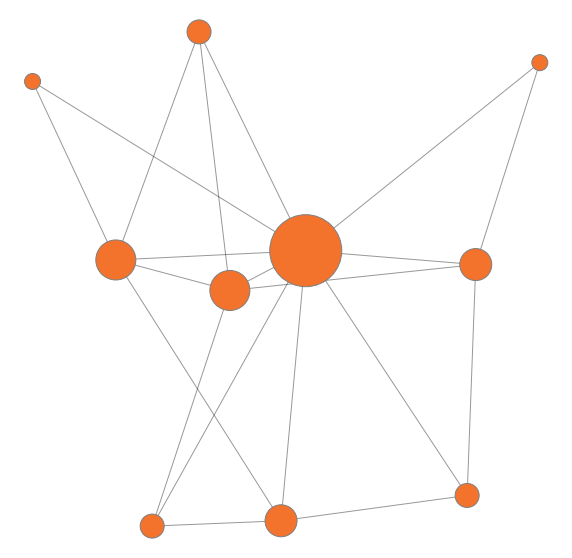

In [104]:
# Create the random graph
degree_distribution = [9, 5, 5, 4, 4, 3, 3, 3, 2, 2]

n_links = sum(degree_distribution) * 0.5

g = create_graph_with_degree_distribution(degree_distribution)

fig, ax = plt.subplots(figsize=(10, 10))
pos = nx.spring_layout(g)
nx.draw_networkx_nodes(
    g,
    pos=pos,
    node_size=[(8*x)**2 for x in degree_distribution],
    node_color="#f3722c",
    edgecolors="gray"
)
nx.draw_networkx_edges(
    g,
    pos=pos,
    color="gray",
    alpha=.4
)
ax.axis("off")
plt.show()

In [105]:
def aggregate_graphs(degree_dist, r, n_iter=10):
    """
    Creates an aggregated graph by merging smaller graphs.
    """
    adj = create_graph_with_degree_distribution(degree_dist, as_adjacency=True)
    
    for i in range(n_iter):
        newadj = create_graph_with_degree_distribution(degree_dist, as_adjacency=True)
        
        p_adj = adj.sum(axis=0)
        p_adj = np.power(p_adj, r)
        p_adj = p_adj / p_adj.sum()
        
        p_adj_new = newadj.sum(axis=0)
        p_adj_new = np.power(p_adj_new, r)
        p_adj_new = p_adj_new / p_adj_new.sum()
        
        i = np.random.choice(np.arange(adj.shape[0]), p=p_adj)
        j = np.random.choice(np.arange(newadj.shape[0]), p=p_adj_new)
        size_adj = adj.shape[0]
        
        # Create new adjacency matrix
        zblock = np.zeros((adj.shape[0], newadj.shape[1]))
        upper = np.concatenate([adj, zblock], axis=1)
        lower = np.concatenate([zblock.T, newadj], axis=1)
        adj = np.concatenate([upper, lower], axis=0)
        
        adj[i, j+size_adj] = 1
        adj[j+size_adj, i] = 1
    
    return nx.from_numpy_array(adj)
        

In [109]:
help(np.block)

Help on function block in module numpy:

block(arrays)
    Assemble an nd-array from nested lists of blocks.
    
    Blocks in the innermost lists are concatenated (see `concatenate`) along
    the last dimension (-1), then these are concatenated along the
    second-last dimension (-2), and so on until the outermost list is reached.
    
    Blocks can be of any dimension, but will not be broadcasted using the normal
    rules. Instead, leading axes of size 1 are inserted, to make ``block.ndim``
    the same for all blocks. This is primarily useful for working with scalars,
    and means that code like ``np.block([v, 1])`` is valid, where
    ``v.ndim == 1``.
    
    When the nested list is two levels deep, this allows block matrices to be
    constructed from their components.
    
    .. versionadded:: 1.13.0
    
    Parameters
    ----------
    arrays : nested list of array_like or scalars (but not tuples)
        If passed a single ndarray or scalar (a nested list of depth 0),

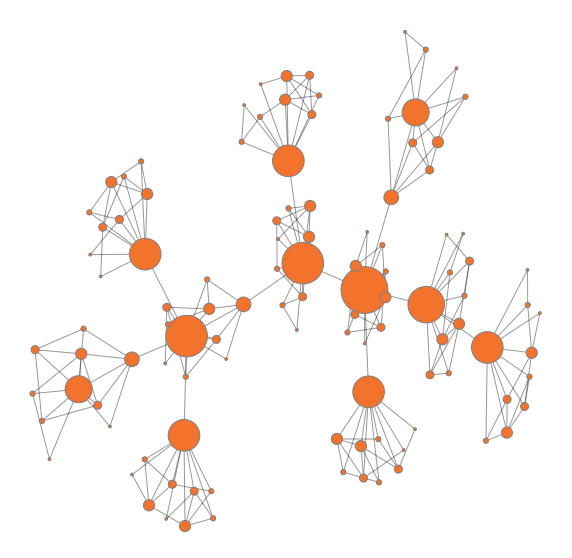

In [112]:
# Create the new aggregate graph
g = aggregate_graphs(degree_distribution, r=4)


fig, ax = plt.subplots(figsize=(10, 10))
pos = nx.kamada_kawai_layout(g)
nx.draw_networkx_nodes(
    g,
    pos=pos,
    node_size=[(x)**3 for x in dict(g.degree).values()],
    node_color="#f3722c",
    edgecolors="gray"
)
nx.draw_networkx_edges(
    g,
    pos=pos,
    color="gray",
    alpha=.4
)
ax.axis("off")
plt.show()